In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [64]:
stockprices = pd.read_csv("../Stocks/NIFTY 50 - Minute data.csv")
print(stockprices.head())

                  date     open     high      low    close  volume
0  2015-01-09 09:15:00  8285.45  8295.90  8285.45  8292.10       0
1  2015-01-09 09:16:00  8292.60  8293.60  8287.20  8288.15       0
2  2015-01-09 09:17:00  8287.40  8293.90  8287.40  8293.90       0
3  2015-01-09 09:18:00  8294.25  8300.65  8293.90  8300.65       0
4  2015-01-09 09:19:00  8300.60  8301.30  8298.75  8301.20       0


In [66]:
test_ratio = 0.2
trainint_ratio = 1 - test_ratio
train_size = int(trainint_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train size : {train_size}")
print(f"test size  : {test_size}")

train   = stockprices[:train_size][["close"]]
test    = stockprices[train_size:][["close"]]

train size : 669405
test size  : 167351


In [70]:
def extract_seqX_outcomeY(data, N, offset):

    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])
    
    return np.squeeze(np.array(X)), np.array(y)

def calculate_rmse(y_true, y_pred):

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def calculate_mape(y_true, y_pred):

    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_perf_metrics(var):

    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["close"]),
        np.array(stockprices[train_size:][var]),
    )

    mape = calculate_mape(
        np.array(stockprices[train_size:]["close"]),
        np.array(stockprices[train_size:][var]),
    )

    return rmse, mape

def plot_stock_trend(var, cur_title, stockprices=stockprices):

    ax = stockprices[["close", var, "10day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["close"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["close"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["lstm_Predictions"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

In [ ]:
window_size = 14

Using LSTM

In [72]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[["close"]])
scaled_data_train = scaled_data[: train.shape[0]]

X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [73]:
raw = stockprices["close"][len(stockprices) - len(test) - window_size:].values
raw = raw.reshape(-1,1)
raw = scaler.transform(raw)

X_test = [raw[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [79]:
layer_units = 50
max_epochs = 100
cur_batch_size = 20

In [80]:
class myLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(myLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        # print("Outsize = ", lstm_out.shape)
        # output = lstm_out[:, -1, :]
        output = self.fc(lstm_out)

        return output

In [81]:
model = myLSTM(input_size=window_size, hidden_size=layer_units, num_layers=3)
train_Dataset = TensorDataset(X_train, y_train)
train_DataLoader = DataLoader(train_Dataset, batch_size=512, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.compile(model)
model.to(device)

OptimizedModule(
  (_orig_mod): myLSTM(
    (lstm): LSTM(14, 50, num_layers=3, batch_first=True)
    (fc): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [83]:
for epoch in tqdm(range(max_epochs)): 
    for data in train_DataLoader:  
        inputs, targets = data

        inputs, targets = inputs.to(device), targets.to(device)  

        # print(inputs.shape, targets.shape)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [15:26<00:00,  9.27s/it]


In [84]:
with torch.no_grad():
    X_test = torch.Tensor(X_test).to(device)
    outputs = model(X_test)

predicted_price = scaler.inverse_transform(outputs.cpu())

In [85]:
test["lstm_Predictions"] = predicted_price

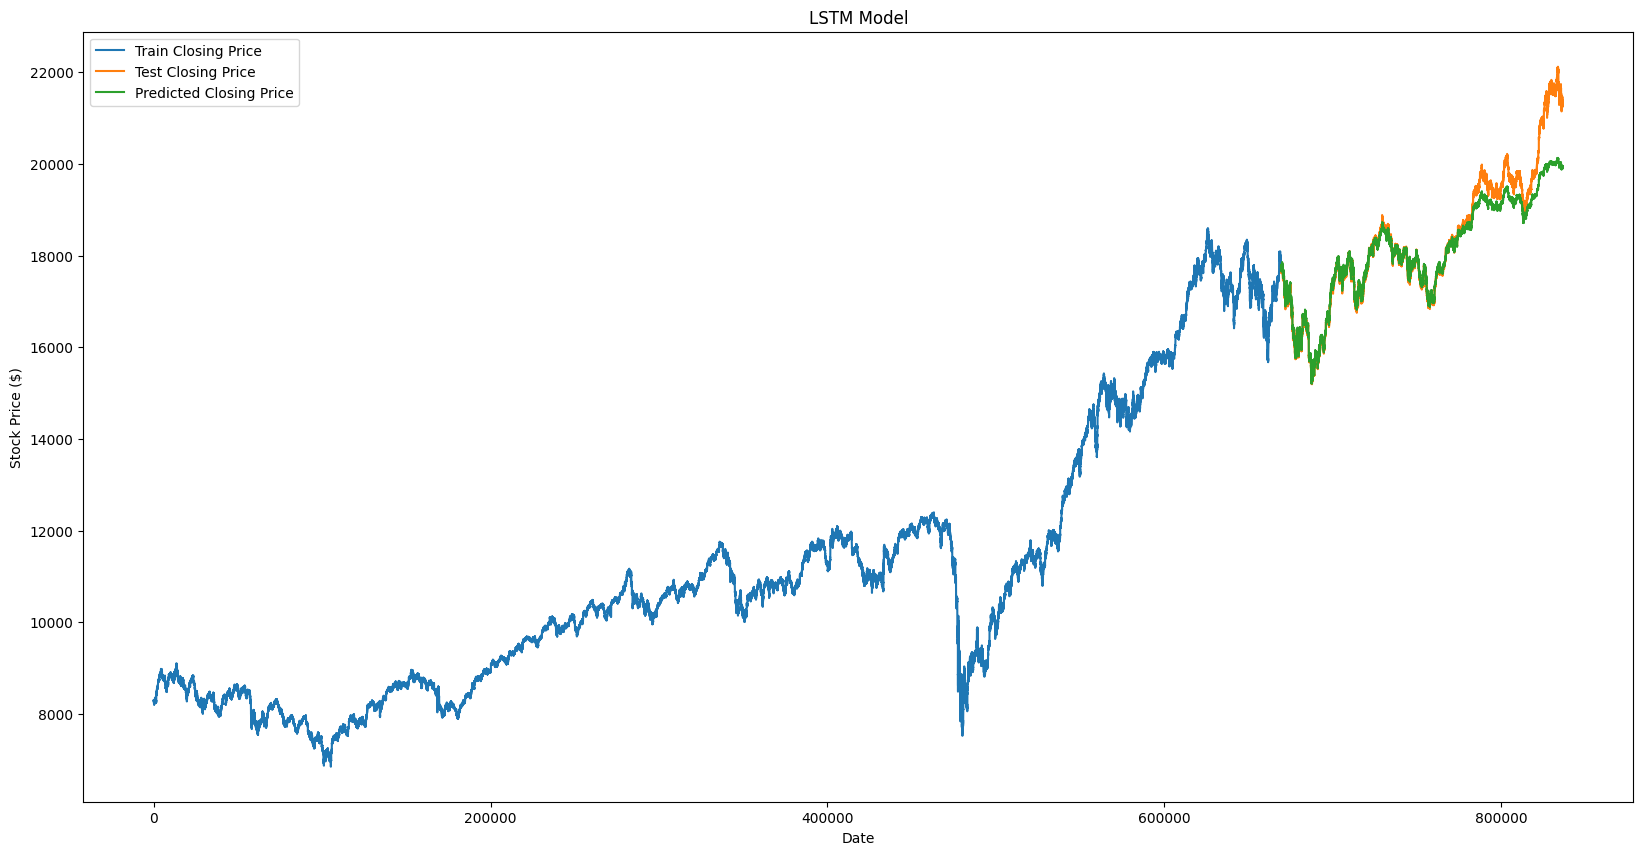

In [86]:
plot_stock_trend_lstm(train, test)

In [91]:
print(X_train.shape, y_train.shape)

torch.Size([669391, 14]) torch.Size([669391, 1])
